## a neural network  with hand coded backpropagation algorithm

In [25]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml

In [26]:
#upload mnsit data
mnist = fetch_openml('mnist_784')
X, y = mnist["data"], mnist["target"]
X = X / 255.0  # normalize input data
# convert class labels to One-Hot encoding
y = OneHotEncoder().fit_transform(y.values.reshape(-1, 1)).toarray()  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


C:\Users\Merve\anaconda3\envs\DSP\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [27]:
# activation functions
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)
# define neural network class
class NeuralNetwork:
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes
        self.weights = [np.random.randn(prev_size, curr_size) * np.sqrt(2 / prev_size)
                        for prev_size, curr_size in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.zeros((1, size)) for size in layer_sizes[1:]]

    def forward(self, X):
        self.acts = [X]
        self.z_val = []

        for i in range(len(self.layer_sizes) - 2):# Forward pass through hidden layers
            z = np.dot(self.acts[-1], self.weights[i]) + self.biases[i]
            self.z_val.append(z)
            a = relu(z)
            self.acts.append(a)
            
        # Forward pass through the output layer
        z = np.dot(self.acts[-1], self.weights[-1]) + self.biases[-1]
        self.z_val.append(z)
        a = softmax(z)
        self.acts.append(a)

        return self.acts[-1]

    def backward(self, X, y, learning_rate):
        m = X.shape[0]
        # Calculate gradients 
        delta = self.acts[-1] - y
        dW = np.dot(self.acts[-2].T, delta) / m
        db = np.sum(delta, axis=0, keepdims=True) / m
        # Update weights and biases of the output layer
        self.weights[-1] -= learning_rate * dW
        self.biases[-1] -= learning_rate * db

        for i in range(len(self.layer_sizes) - 3, -1, -1):# Backpropagate through the hidden layers
            delta = np.dot(delta, self.weights[i + 1].T) * (self.z_val[i] > 0)
            dW = np.dot(self.acts[i].T, delta) / m
            db = np.sum(delta, axis=0, keepdims=True) / m
            # Update weights and biases of the output layer
            self.weights[i] -= learning_rate * dW
            self.biases[i] -= learning_rate * db

    def train(self, X_train, y_train, epochs, learning_rate, batch_size):
        m = X_train.shape[0]
        for epoch in range(epochs):
            for i in range(0, m, batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                # forward and backward pass for each batch
                output = self.forward(X_batch)
                self.backward(X_batch, y_batch, learning_rate)
            # Calculate loss and accuracy
            loss = -np.mean(y_train * np.log(self.forward(X_train) + 1e-8))
            accuracy = self.evaluate(X_train, y_train)
            print(f"Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.2%}")

                
    def evaluate(self, X, y):
        predict = self.forward(X)
        pred = np.argmax(predict, axis=1)
        true = np.argmax(y, axis=1)
        accuracy = np.mean(pred == true)
        return accuracy


In [29]:

# Create an instance of the neural network
network = NeuralNetwork([784, 128, 64, 10])

# Train the network
network.train(X_train, y_train, epochs=10, learning_rate=0.01, batch_size=128)

# Perform forward pass on the test set
predictions = network.forward(X_test)

# Convert predictions to class labels
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = np.mean(y_pred == y_true)
print(f"Accuracy: {accuracy * 100:.2f}%")

Epoch 0: Loss = 0.0576, Accuracy = 85.28%
Epoch 1: Loss = 0.0403, Accuracy = 88.91%
Epoch 2: Loss = 0.0345, Accuracy = 90.28%
Epoch 3: Loss = 0.0312, Accuracy = 91.06%
Epoch 4: Loss = 0.0289, Accuracy = 91.69%
Epoch 5: Loss = 0.0271, Accuracy = 92.19%
Epoch 6: Loss = 0.0256, Accuracy = 92.65%
Epoch 7: Loss = 0.0243, Accuracy = 92.97%
Epoch 8: Loss = 0.0232, Accuracy = 93.37%
Epoch 9: Loss = 0.0222, Accuracy = 93.65%
Accuracy: 93.49%


## compare the results to a network developed in Keras

In [30]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml
from tensorflow import keras
from tensorflow.keras import layers,optimizers
#upload mnsit data
mnist = fetch_openml('mnist_784')
X, y = mnist["data"], mnist["target"]
X = X / 255.0  # Normalize the input data
y = OneHotEncoder().fit_transform(y.values.reshape(-1, 1)).toarray()  # Convert y to a NumPy array and reshape

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(784,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])
# Define the optimizer
optimizer = optimizers.SGD(learning_rate=0.01)
# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=128, epochs=10,validation_split=0.1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%")


C:\Users\Merve\anaconda3\envs\DSP\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Epoch 1/10
394/394 [==============================] - 13s 32ms/step - loss: 1.4277 - accuracy: 0.6421 - val_loss: 0.7457 - val_accuracy: 0.8295
Epoch 2/10
394/394 [==============================] - 13s 33ms/step - loss: 0.5747 - accuracy: 0.8579 - val_loss: 0.4542 - val_accuracy: 0.8818
Epoch 3/10
394/394 [==============================] - 13s 33ms/step - loss: 0.4251 - accuracy: 0.8843 - val_loss: 0.3756 - val_accuracy: 0.8991
Epoch 4/10
394/394 [==============================] - 12s 30ms/step - loss: 0.3690 - accuracy: 0.8969 - val_loss: 0.3334 - val_accuracy: 0.9079
Epoch 5/10
394/394 [==============================] - 13s 34ms/step - loss: 0.3362 - accuracy: 0.9044 - val_loss: 0.3091 - val_accuracy: 0.9157
Epoch 6/10
394/394 [==============================] - 14s 35ms/step - loss: 0.3134 - accuracy: 0.9104 - val_loss: 0.2896 - val_accuracy: 0.9204
Epoch 7/10
394/394 [==============================] - 14s 35ms/step - loss: 0.2953 - accuracy: 0.9152 - val_loss: 0.2736 - val_accuracy:

In [31]:
history.history['loss']

[1.4277395009994507,
 0.5747122168540955,
 0.4250909984111786,
 0.36903563141822815,
 0.33620360493659973,
 0.31339001655578613,
 0.2953481376171112,
 0.2804419994354248,
 0.26787447929382324,
 0.2565949559211731]

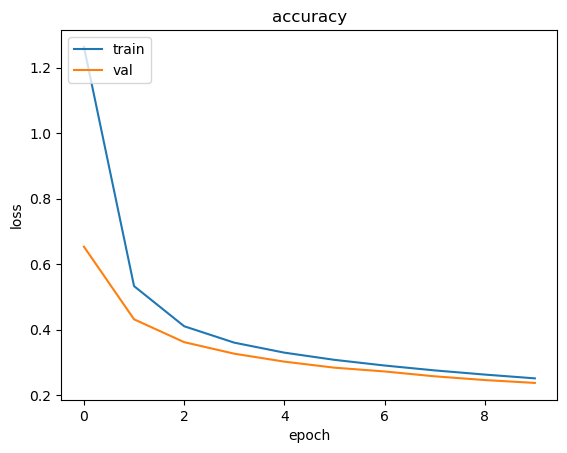

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Both networks have the same number of neurons, layers, epochs, learning rate, and batch size. If we compare the results, the accuracy values ​​of both neural networks are over 90 percent, so it can be said that they are successful.